#**CELLA 0 - GLOBAL CONFIG**

In [14]:
# ============================================================================
# CELL 0: Global config
# ============================================================================

# Split strategy:
# - "global_date"  = stesso tuo split, ma fatto separatamente per A e B
# - "per_user"     = split 80/20 all'interno di ogni user_id (consigliato)
SPLIT_STRATEGY = "global_date"

# Se True, include lag dei target come predittori (setting autoregressivo)
USE_TARGET_LAGS = True

# Se True, salva due dataset separati (A e B)
SAVE_SEPARATE_PIPELINES = True

# Se True, per Pipeline B filtra solo acwr_valid=True (coerente col target design)
PIPELINE_B_REQUIRE_ACWR_VALID = True

print("CONFIG:")
print(f"  SPLIT_STRATEGY={SPLIT_STRATEGY}")
print(f"  USE_TARGET_LAGS={USE_TARGET_LAGS}")
print(f"  SAVE_SEPARATE_PIPELINES={SAVE_SEPARATE_PIPELINES}")
print(f"  PIPELINE_B_REQUIRE_ACWR_VALID={PIPELINE_B_REQUIRE_ACWR_VALID}")


CONFIG:
  SPLIT_STRATEGY=global_date
  USE_TARGET_LAGS=True
  SAVE_SEPARATE_PIPELINES=True
  PIPELINE_B_REQUIRE_ACWR_VALID=True


#**CELL 1 - Setup & Caricamento Dataset Fixed**

In [15]:
# ============================================================================
# CELL 1: Setup & Caricamento Dataset Fixed
# ============================================================================
"""
IMPETUS_Feature_Engineering.ipynb
Autore: Alessandro Ambrosio

OBIETTIVO:
Feature engineering per le due pipeline IMPETUS:
- Pipeline A: Performance Score regression (0-10)
- Pipeline B: Injury Risk Score regression (0-10)

STRATEGIA FE:
1. Rolling windows (7d, 14d, 28d) per temporal context
2. Lag features (7d, 14d) per history
3. Trend features (delta, acceleration) per progression
4. Multicollinearity handling (drop TSB, corr fitness 0.989)
5. Temporal split 80/20 (NO shuffle!)
6. Feature scaling (StandardScaler)

INPUT: banister_daily_sampled_fixed.csv (106,571 × 15)
OUTPUT: impetus_train.csv, impetus_test.csv, scaler.pkl
"""

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("IMPETUS FEATURE ENGINEERING")
print("=" * 80)
print()

# Caricamento dataset fixed
DATA_DIR = Path('data/synth_set_level_v2')
df = pd.read_csv(DATA_DIR / 'banister_daily_sampled_fixed.csv')

print(f"Dataset caricato: {df.shape[0]:,} righe x {df.shape[1]} colonne")
print()

# Converti date e sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['user_id', 'date']).reset_index(drop=True)

print("Colonne disponibili:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")
print()

print("Info dataset:")
print(f"   Users: {df['user_id'].nunique()}")
print(f"   Periodo: {df['date'].min().date()} -> {df['date'].max().date()}")
print(f"   Durata: {(df['date'].max() - df['date'].min()).days} giorni")
print(f"   Giorni per user (media): {len(df) / df['user_id'].nunique():.1f}")

IMPETUS FEATURE ENGINEERING

Dataset caricato: 106,571 righe x 16 colonne

Colonne disponibili:
    1. user_id
    2. date
    3. impulse
    4. tau_F
    5. tau_D
    6. beta_F
    7. beta_D
    8. fitness
    9. fatigue
   10. performance
   11. TSB
   12. acwr_valid
   13. acwr
   14. performance_score_0_10
   15. injury_risk_score
   16. experience_label

Info dataset:
   Users: 510
   Periodo: 2023-02-26 -> 2026-02-08
   Durata: 1078 giorni
   Giorni per user (media): 209.0


#**CELL 2 - Rolling Windows (7d, 14d, 28d)**

In [16]:
# ============================================================================
# CELL 2: Rolling Windows (7d, 14d, 28d)
# ============================================================================
"""
Creazione rolling windows per catturare temporal context.
Windows: 7d (short-term), 14d (medium-term), 28d (long-term).
"""

print("\n" + "=" * 80)
print("SEZIONE 1: ROLLING WINDOWS (7d, 14d, 28d)")
print("=" * 80)

# Features candidate per rolling
rolling_features = ['TSB', 'acwr', 'fitness', 'impulse']

print("\nCalcolo rolling windows...")
print()

# 7-day windows (short-term)
print("7-DAY WINDOWS:")
for feat in rolling_features:
    col_name = f'{feat}_rolling_7d_mean'
    df[col_name] = df.groupby('user_id')[feat].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    print(f"   [OK] {col_name}")

# 14-day windows (medium-term)
print("\n14-DAY WINDOWS:")
for feat in rolling_features:
    col_name = f'{feat}_rolling_14d_mean'
    df[col_name] = df.groupby('user_id')[feat].transform(
        lambda x: x.rolling(14, min_periods=1).mean()
    )
    print(f"   [OK] {col_name}")

# 28-day windows (long-term)
print("\n28-DAY WINDOWS:")
for feat in rolling_features:
    col_name = f'{feat}_rolling_28d_mean'
    df[col_name] = df.groupby('user_id')[feat].transform(
        lambda x: x.rolling(28, min_periods=7).mean()
    )
    print(f"   [OK] {col_name}")

# Rolling std per ACWR (volatility)
df['acwr_rolling_7d_std'] = df.groupby('user_id')['acwr'].transform(
    lambda x: x.rolling(7, min_periods=1).std()
)
df['acwr_rolling_14d_std'] = df.groupby('user_id')['acwr'].transform(
    lambda x: x.rolling(14, min_periods=1).std()
)
print("\nACWR VOLATILITY:")
print(f"   [OK] acwr_rolling_7d_std")
print(f"   [OK] acwr_rolling_14d_std")

print(f"\n[OK] Rolling windows create: {4*3 + 2} = 14 features")
print(f"    Shape: {df.shape}")


SEZIONE 1: ROLLING WINDOWS (7d, 14d, 28d)

Calcolo rolling windows...

7-DAY WINDOWS:
   [OK] TSB_rolling_7d_mean
   [OK] acwr_rolling_7d_mean
   [OK] fitness_rolling_7d_mean
   [OK] impulse_rolling_7d_mean

14-DAY WINDOWS:
   [OK] TSB_rolling_14d_mean
   [OK] acwr_rolling_14d_mean
   [OK] fitness_rolling_14d_mean
   [OK] impulse_rolling_14d_mean

28-DAY WINDOWS:
   [OK] TSB_rolling_28d_mean
   [OK] acwr_rolling_28d_mean
   [OK] fitness_rolling_28d_mean
   [OK] impulse_rolling_28d_mean

ACWR VOLATILITY:
   [OK] acwr_rolling_7d_std
   [OK] acwr_rolling_14d_std

[OK] Rolling windows create: 14 = 14 features
    Shape: (106571, 30)


#**CELL 3 - Lag Features (7d, 14d)**

In [17]:
# ============================================================================
# CELL 3 (MOD): Lag Features (7d, 14d) con toggle per target-lags
# ============================================================================

print("\n" + "=" * 80)
print("SEZIONE 2: LAG FEATURES (7d, 14d)")
print("=" * 80)

# Features per lag (sempre)
lag_features = ['TSB', 'acwr', 'fitness', 'fatigue']

# (Opzionale) target-lags: setting autoregressivo
if USE_TARGET_LAGS:
    lag_features += ['performance_score_0_10', 'injury_risk_score']

print("\nCalcolo lag features...")
print(f"USE_TARGET_LAGS={USE_TARGET_LAGS}")
print()

for lag in [7, 14]:
    print(f"{lag}-DAY LAGS:")
    for feat in lag_features:
        col_name = f'{feat}_lag_{lag}d'
        df[col_name] = df.groupby('user_id')[feat].shift(lag)
        print(f"   [OK] {col_name}")
    print()

n_created = len(lag_features) * 2
print(f"[OK] Lag features create: {n_created} features")
print(f"     Shape: {df.shape}")

lag_cols = [c for c in df.columns if '_lag_' in c]
missing_lags = df[lag_cols].isna().sum().sum()
missing_pct = missing_lags / (len(df) * len(lag_cols)) * 100
print(f"\n[INFO] Missing values da lag: {missing_lags:,} ({missing_pct:.1f}%)")
print("       Causa: Primi 7-14 giorni per user (normale)")



SEZIONE 2: LAG FEATURES (7d, 14d)

Calcolo lag features...
USE_TARGET_LAGS=True

7-DAY LAGS:
   [OK] TSB_lag_7d
   [OK] acwr_lag_7d
   [OK] fitness_lag_7d
   [OK] fatigue_lag_7d
   [OK] performance_score_0_10_lag_7d
   [OK] injury_risk_score_lag_7d

14-DAY LAGS:
   [OK] TSB_lag_14d
   [OK] acwr_lag_14d
   [OK] fitness_lag_14d
   [OK] fatigue_lag_14d
   [OK] performance_score_0_10_lag_14d
   [OK] injury_risk_score_lag_14d

[OK] Lag features create: 12 features
     Shape: (106571, 42)

[INFO] Missing values da lag: 118,854 (9.3%)
       Causa: Primi 7-14 giorni per user (normale)


#**CELL 4 - Trend Features (Delta, Acceleration)**

In [18]:
# ============================================================================
# CELL 4: Trend Features (Delta, Acceleration)
# ============================================================================
"""
Trend features per catturare progression patterns.
- Delta: Cambiamento assoluto su finestra
- Acceleration: Variazione velocità cambiamento
"""

print("\n" + "=" * 80)
print("SEZIONE 3: TREND FEATURES (Delta, Acceleration)")
print("=" * 80)

print("\nCalcolo trend features...")
print()

# Delta features (cambiamento 28d)
print("DELTA FEATURES (28-day change):")
trend_features = ['fitness', 'TSB', 'impulse']
for feat in trend_features:
    col_name = f'delta_{feat}_28d'
    df[col_name] = df[feat] - df.groupby('user_id')[feat].shift(28)
    print(f"   [OK] {col_name}")

# Trend slope (change per day over 14d)
print("\nTREND SLOPE (14-day rate):")
for feat in ['TSB', 'fitness']:
    col_name = f'{feat}_trend_14d'
    lag_14 = df.groupby('user_id')[feat].shift(14)
    df[col_name] = (df[feat] - lag_14) / 14  # Slope per day
    print(f"   [OK] {col_name}")

# ACWR acceleration (spike detection)
print("\nACWR ACCELERATION:")
df['acwr_acceleration_7d'] = df['acwr'] - df.groupby('user_id')['acwr'].shift(7)
print(f"   [OK] acwr_acceleration_7d")

print(f"\n[OK] Trend features create: {len(trend_features) + 2 + 1} = 6 features")
print(f"    Shape: {df.shape}")


SEZIONE 3: TREND FEATURES (Delta, Acceleration)

Calcolo trend features...

DELTA FEATURES (28-day change):
   [OK] delta_fitness_28d
   [OK] delta_TSB_28d
   [OK] delta_impulse_28d

TREND SLOPE (14-day rate):
   [OK] TSB_trend_14d
   [OK] fitness_trend_14d

ACWR ACCELERATION:
   [OK] acwr_acceleration_7d

[OK] Trend features create: 6 = 6 features
    Shape: (106571, 48)


#**CELL 5 - Interaction Terms**

In [19]:
# ============================================================================
# CELL 5: Interaction Terms
# ============================================================================
"""
Interaction features per catturare synergies.
Key interactions identificate da EDA:
- TSB × ACWR (forma vs carico)
- fitness × fatigue (balance check)
"""

print("\n" + "=" * 80)
print("SEZIONE 4: INTERACTION TERMS")
print("=" * 80)

print("\nCalcolo interaction features...")
print()

# TSB × ACWR (forma alta + spike = pericoloso)
df['TSB_x_ACWR'] = df['TSB'] * df['acwr']
print("   [OK] TSB_x_ACWR (forma vs carico)")

# Fitness × Fatigue (balance ratio)
df['fitness_x_fatigue'] = df['fitness'] * df['fatigue']
print("   [OK] fitness_x_fatigue (balance)")

# Impulse × ACWR (volume + spike intensity)
df['impulse_x_acwr'] = df['impulse'] * df['acwr']
print("   [OK] impulse_x_acwr (volume intensity)")

print(f"\n[OK] Interaction features create: 3 features")
print(f"    Shape: {df.shape}")



SEZIONE 4: INTERACTION TERMS

Calcolo interaction features...

   [OK] TSB_x_ACWR (forma vs carico)
   [OK] fitness_x_fatigue (balance)
   [OK] impulse_x_acwr (volume intensity)

[OK] Interaction features create: 3 features
    Shape: (106571, 51)


#**CELL 6 - Multicollinearity Handling**

In [20]:
# ============================================================================
# CELL 6: Multicollinearity Handling
# ============================================================================
"""
Gestione multicollinearity rilevata da EDA:
- fitness vs TSB: 0.989 (CRITICA!)
- fitness vs fatigue: 0.930 (alta)

DECISIONE: Drop TSB e derivati (mantiene fitness + fatigue, più interpretabili).
TSB = fitness - fatigue (ridondante by design).
"""

print("\n" + "=" * 80)
print("SEZIONE 5: MULTICOLLINEARITY HANDLING")
print("=" * 80)

print("\nRICAPO CORRELAZIONI DA EDA:")
print("   fitness vs TSB: 0.989 (CRITICA)")
print("   fitness vs fatigue: 0.930 (alta)")
print("   TSB = fitness - fatigue (ridondanza strutturale)")
print()

print("DECISIONE: Drop TSB e derivati")
print("   Mantiene: fitness, fatigue (interpretabili)")
print("   Drop: TSB, TSB_rolling_*, TSB_lag_*, delta_TSB_*, TSB_trend_*")
print()

# Identifica colonne TSB da droppare
cols_to_drop = [col for col in df.columns if 'TSB' in col and col != 'TSB_x_ACWR']
# Nota: TSB_x_ACWR manteniamo (interaction utile, non pura ridondanza)

print(f"Colonne da droppare ({len(cols_to_drop)}):")
for col in cols_to_drop:
    print(f"   - {col}")
print()

# Drop
df_reduced = df.drop(columns=cols_to_drop)

print(f"[OK] Multicollinearity gestita")
print(f"    Shape prima: {df.shape}")
print(f"    Shape dopo: {df_reduced.shape}")
print(f"    Features droppate: {len(cols_to_drop)}")

# Update df
df = df_reduced


SEZIONE 5: MULTICOLLINEARITY HANDLING

RICAPO CORRELAZIONI DA EDA:
   fitness vs TSB: 0.989 (CRITICA)
   fitness vs fatigue: 0.930 (alta)
   TSB = fitness - fatigue (ridondanza strutturale)

DECISIONE: Drop TSB e derivati
   Mantiene: fitness, fatigue (interpretabili)
   Drop: TSB, TSB_rolling_*, TSB_lag_*, delta_TSB_*, TSB_trend_*

Colonne da droppare (8):
   - TSB
   - TSB_rolling_7d_mean
   - TSB_rolling_14d_mean
   - TSB_rolling_28d_mean
   - TSB_lag_7d
   - TSB_lag_14d
   - delta_TSB_28d
   - TSB_trend_14d

[OK] Multicollinearity gestita
    Shape prima: (106571, 51)
    Shape dopo: (106571, 43)
    Features droppate: 8


#**CELL 7 - Feature Summary & Selection**

In [21]:
# ============================================================================
# CELL 7: Feature Summary & Selection
# ============================================================================
"""
Summary features create e selezione finale per modeling.
"""

print("\n" + "=" * 80)
print("SEZIONE 6: FEATURE SUMMARY")
print("=" * 80)

# Categorizza features
base_features = ['impulse', 'tau_F', 'tau_D', 'beta_F', 'beta_D',
                 'fitness', 'fatigue', 'performance', 'acwr']
rolling_features_cols = [col for col in df.columns if 'rolling' in col]
lag_features_cols = [col for col in df.columns if 'lag' in col]
trend_features_cols = [col for col in df.columns if 'delta' in col or 'trend' in col or 'acceleration' in col]
interaction_features_cols = [col for col in df.columns if '_x_' in col]
target_cols = ['performance_score_0_10', 'injury_risk_score']
meta_cols = ['user_id', 'date', 'experience_label']

print("\nFEATURE CATEGORIES:")
print(f"   Base Banister: {len(base_features)} features")
print(f"   Rolling windows: {len(rolling_features_cols)} features")
print(f"   Lag features: {len(lag_features_cols)} features")
print(f"   Trend features: {len(trend_features_cols)} features")
print(f"   Interaction terms: {len(interaction_features_cols)} features")
print(f"   Targets: {len(target_cols)} features")
print(f"   Metadata: {len(meta_cols)} features")
print()

total_features = len(base_features) + len(rolling_features_cols) + len(lag_features_cols) + len(trend_features_cols) + len(interaction_features_cols)
print(f"TOTALE FEATURES ENGINEERED: {total_features}")
print()

# Feature list per modeling (esclude metadata)
feature_cols = (base_features + rolling_features_cols + lag_features_cols +
                trend_features_cols + interaction_features_cols)

print(f"FEATURES PER MODELING: {len(feature_cols)}")
print()

# Sample 10 features
print("Sample features (prime 10):")
for i, feat in enumerate(feature_cols[:10], 1):
    print(f"   {i:2d}. {feat}")
print(f"   ... (+{len(feature_cols) - 10} features)")



SEZIONE 6: FEATURE SUMMARY

FEATURE CATEGORIES:
   Base Banister: 9 features
   Rolling windows: 11 features
   Lag features: 10 features
   Trend features: 4 features
   Interaction terms: 3 features
   Targets: 2 features
   Metadata: 3 features

TOTALE FEATURES ENGINEERED: 37

FEATURES PER MODELING: 37

Sample features (prime 10):
    1. impulse
    2. tau_F
    3. tau_D
    4. beta_F
    5. beta_D
    6. fitness
    7. fatigue
    8. performance
    9. acwr
   10. acwr_rolling_7d_mean
   ... (+27 features)


#**CELL 8 - Temporal Train/Test Split**

In [22]:
# ============================================================================
# CELL 8: Clean dataset per Pipeline A/B + Split temporale configurabile
# ============================================================================

print("\n" + "=" * 80)
print("SEZIONE 7: TEMPORAL TRAIN/TEST SPLIT (A/B)")
print("=" * 80)

def temporal_split_global_date(df_in, frac=0.80):
    df_in = df_in.sort_values('date').reset_index(drop=True)
    split_date = df_in['date'].quantile(frac)
    train = df_in[df_in['date'] <= split_date].copy()
    test  = df_in[df_in['date'] >  split_date].copy()
    return train, test, split_date

def temporal_split_per_user(df_in, frac=0.80):
    df_in = df_in.sort_values(['user_id', 'date']).copy()
    cut = df_in.groupby('user_id')['date'].quantile(frac).rename('cut').reset_index()
    df2 = df_in.merge(cut, on='user_id', how='left')
    train = df2[df2['date'] <= df2['cut']].drop(columns='cut').copy()
    test  = df2[df2['date'] >  df2['cut']].drop(columns='cut').copy()
    return train, test, None

print("\nPRE-PROCESSING: drop missing su feature + target (separato per pipeline)")
print(f"SPLIT_STRATEGY={SPLIT_STRATEGY}")

# --- Pipeline A clean
df_clean_A = df.dropna(subset=feature_cols + ['performance_score_0_10', 'experience_label']).copy()

# --- Pipeline B clean
df_tmp_B = df.copy()
if PIPELINE_B_REQUIRE_ACWR_VALID:
    df_tmp_B = df_tmp_B[df_tmp_B['acwr_valid']].copy()

df_clean_B = df_tmp_B.dropna(subset=feature_cols + ['injury_risk_score', 'experience_label']).copy()

print("\nCLEAN SHAPES:")
print(f"  df_clean_A: {df_clean_A.shape}")
print(f"  df_clean_B: {df_clean_B.shape}")

# --- Split A
if SPLIT_STRATEGY == "per_user":
    train_A, test_A, split_date_A = temporal_split_per_user(df_clean_A, 0.80)
else:
    train_A, test_A, split_date_A = temporal_split_global_date(df_clean_A, 0.80)

# --- Split B
if SPLIT_STRATEGY == "per_user":
    train_B, test_B, split_date_B = temporal_split_per_user(df_clean_B, 0.80)
else:
    train_B, test_B, split_date_B = temporal_split_global_date(df_clean_B, 0.80)

def print_split_report(name, tr, te, split_date):
    print("\n" + "-"*80)
    print(f"SPLIT RESULT [{name}]")
    if split_date is not None:
        print(f"  SPLIT DATE: {split_date.date()}")
    print(f"  Train: {len(tr):,} righe | Periodo: {tr['date'].min().date()} -> {tr['date'].max().date()} | Users: {tr['user_id'].nunique():,}")
    print(f"  Test : {len(te):,} righe | Periodo: {te['date'].min().date()} -> {te['date'].max().date()} | Users: {te['user_id'].nunique():,}")
    print("\n  EXPERIENCE DISTRIBUTION (Train vs Test):")
    tr_exp = tr['experience_label'].value_counts(normalize=True).sort_index() * 100
    te_exp = te['experience_label'].value_counts(normalize=True).sort_index() * 100
    levels = sorted(set(tr_exp.index) | set(te_exp.index))
    for exp in levels:
        a = tr_exp.get(exp, 0.0)
        b = te_exp.get(exp, 0.0)
        print(f"    {exp:15s}: Train {a:5.1f}%, Test {b:5.1f}% (diff {abs(a-b):.1f}%)")

print_split_report("Pipeline A (performance)", train_A, test_A, split_date_A)
print_split_report("Pipeline B (injury risk)", train_B, test_B, split_date_B)



SEZIONE 7: TEMPORAL TRAIN/TEST SPLIT (A/B)

PRE-PROCESSING: drop missing su feature + target (separato per pipeline)
SPLIT_STRATEGY=global_date

CLEAN SHAPES:
  df_clean_A: (85825, 43)
  df_clean_B: (85825, 43)

--------------------------------------------------------------------------------
SPLIT RESULT [Pipeline A (performance)]
  SPLIT DATE: 2025-11-19
  Train: 68,694 righe | Periodo: 2023-05-06 -> 2025-11-19 | Users: 426
  Test : 17,131 righe | Periodo: 2025-11-20 -> 2026-02-08 | Users: 496

  EXPERIENCE DISTRIBUTION (Train vs Test):
    Advanced       : Train  69.5%, Test  36.4% (diff 33.1%)
    Beginner       : Train   3.1%, Test  28.0% (diff 24.9%)
    Intermediate   : Train  27.4%, Test  35.6% (diff 8.1%)

--------------------------------------------------------------------------------
SPLIT RESULT [Pipeline B (injury risk)]
  SPLIT DATE: 2025-11-19
  Train: 68,694 righe | Periodo: 2023-05-06 -> 2025-11-19 | Users: 426
  Test : 17,131 righe | Periodo: 2025-11-20 -> 2026-02-08 

#**CELL 9 - Feature Scaling**

In [23]:
# ============================================================================
# CELL 9: Feature Scaling (StandardScaler) separato per A e B
#            + drop automatico feature costanti nel train
# ============================================================================

print("\n" + "=" * 80)
print("SEZIONE 8: FEATURE SCALING (A/B) + DROP CONSTANT FEATURES")
print("=" * 80)

def scale_pipeline(train_df, test_df, feature_cols_in, meta_cols, y_col, scaler_name="scaler"):
    X_train = train_df[feature_cols_in].copy()
    X_test  = test_df[feature_cols_in].copy()

    # Drop constant features basato SOLO su train
    nuniq = X_train.nunique(dropna=False)
    constant_cols = nuniq[nuniq <= 1].index.tolist()
    feature_cols_out = [c for c in feature_cols_in if c not in constant_cols]

    if constant_cols:
        print(f"[{scaler_name}] Constant cols dropped ({len(constant_cols)}): {constant_cols}")

    X_train = X_train[feature_cols_out]
    X_test  = X_test[feature_cols_out]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=feature_cols_out, index=X_train.index)
    X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=feature_cols_out, index=X_test.index)

    train_meta = train_df[meta_cols].copy()
    test_meta  = test_df[meta_cols].copy()
    y_train = train_df[y_col].copy()
    y_test  = test_df[y_col].copy()

    train_final = pd.concat([train_meta.reset_index(drop=True),
                             X_train_scaled.reset_index(drop=True),
                             y_train.reset_index(drop=True).rename(y_col)], axis=1)
    test_final = pd.concat([test_meta.reset_index(drop=True),
                            X_test_scaled.reset_index(drop=True),
                            y_test.reset_index(drop=True).rename(y_col)], axis=1)

    return train_final, test_final, scaler, feature_cols_out, constant_cols

meta_cols = ['user_id', 'date', 'experience_label']

print("\n[PIPELINE A] scaling su target performance_score_0_10")
train_final_A, test_final_A, scaler_A, feature_cols_A, const_A = scale_pipeline(
    train_A, test_A, feature_cols, meta_cols, 'performance_score_0_10', scaler_name="A"
)

print(f"[OK] Train A final: {train_final_A.shape}")
print(f"[OK] Test  A final: {test_final_A.shape}")
print(f"[OK] n_features A: {len(feature_cols_A)}")

print("\n[PIPELINE B] scaling su target injury_risk_score")
train_final_B, test_final_B, scaler_B, feature_cols_B, const_B = scale_pipeline(
    train_B, test_B, feature_cols, meta_cols, 'injury_risk_score', scaler_name="B"
)

print(f"[OK] Train B final: {train_final_B.shape}")
print(f"[OK] Test  B final: {test_final_B.shape}")
print(f"[OK] n_features B: {len(feature_cols_B)}")



SEZIONE 8: FEATURE SCALING (A/B) + DROP CONSTANT FEATURES

[PIPELINE A] scaling su target performance_score_0_10
[A] Constant cols dropped (2): ['beta_F', 'beta_D']
[OK] Train A final: (68694, 39)
[OK] Test  A final: (17131, 39)
[OK] n_features A: 35

[PIPELINE B] scaling su target injury_risk_score
[B] Constant cols dropped (2): ['beta_F', 'beta_D']
[OK] Train B final: (68694, 39)
[OK] Test  B final: (17131, 39)
[OK] n_features B: 35


#**CELL 10 - Save Preprocessed Data & Metadata**

In [24]:
# ============================================================================
# CELL 10: Save Preprocessed Data & Metadata (A/B)
# ============================================================================

print("\n" + "=" * 80)
print("SEZIONE 9: SAVE PREPROCESSED DATA (A/B)")
print("=" * 80)

output_dir = Path('models')
output_dir.mkdir(exist_ok=True)

DATA_DIR = Path('data/synth_set_level_v2')
DATA_DIR.mkdir(exist_ok=True, parents=True)

if SAVE_SEPARATE_PIPELINES:
    trainA_path = DATA_DIR / 'impetus_train_A.csv'
    testA_path  = DATA_DIR / 'impetus_test_A.csv'
    trainB_path = DATA_DIR / 'impetus_train_B.csv'
    testB_path  = DATA_DIR / 'impetus_test_B.csv'

    train_final_A.to_csv(trainA_path, index=False)
    test_final_A.to_csv(testA_path, index=False)
    train_final_B.to_csv(trainB_path, index=False)
    test_final_B.to_csv(testB_path, index=False)

    print(f"[OK] Train A saved: {trainA_path} ({trainA_path.stat().st_size/(1024**2):.1f} MB)")
    print(f"[OK] Test  A saved: {testA_path} ({testA_path.stat().st_size/(1024**2):.1f} MB)")
    print(f"[OK] Train B saved: {trainB_path} ({trainB_path.stat().st_size/(1024**2):.1f} MB)")
    print(f"[OK] Test  B saved: {testB_path} ({testB_path.stat().st_size/(1024**2):.1f} MB)")
else:
    # fallback (se vuoi mantenere 1 solo file, non consigliato)
    train_path = DATA_DIR / 'impetus_train.csv'
    test_path  = DATA_DIR / 'impetus_test.csv'
    raise ValueError("SAVE_SEPARATE_PIPELINES=False non supportato in questa versione (per evitare confusione A/B).")

# Save scalers
scalerA_path = output_dir / 'impetus_scaler_A.pkl'
scalerB_path = output_dir / 'impetus_scaler_B.pkl'
with open(scalerA_path, 'wb') as f:
    pickle.dump(scaler_A, f)
with open(scalerB_path, 'wb') as f:
    pickle.dump(scaler_B, f)

print(f"[OK] Scaler A saved: {scalerA_path} ({scalerA_path.stat().st_size/1024:.1f} KB)")
print(f"[OK] Scaler B saved: {scalerB_path} ({scalerB_path.stat().st_size/1024:.1f} KB)")

# Save metadata (unico file con 2 sezioni)
metadata = {
    "split_strategy": SPLIT_STRATEGY,
    "use_target_lags": USE_TARGET_LAGS,
    "pipeline_b_require_acwr_valid": PIPELINE_B_REQUIRE_ACWR_VALID,
    "pipelines": {
        "A": {
            "target": "performance_score_0_10",
            "feature_cols": feature_cols_A,
            "train_shape": train_final_A.shape,
            "test_shape": test_final_A.shape,
            "constant_cols_dropped": const_A,
            "split_date": None if split_date_A is None else str(split_date_A.date())
        },
        "B": {
            "target": "injury_risk_score",
            "feature_cols": feature_cols_B,
            "train_shape": train_final_B.shape,
            "test_shape": test_final_B.shape,
            "constant_cols_dropped": const_B,
            "split_date": None if split_date_B is None else str(split_date_B.date())
        }
    },
    "meta_cols": meta_cols
}

metadata_path = output_dir / 'impetus_feature_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"[OK] Metadata saved: {metadata_path} ({metadata_path.stat().st_size/1024:.1f} KB)")

print("\nNEXT STEP:")
print("  - IMPETUS_Modeling_A.ipynb (Performance Score regression)")
print("  - IMPETUS_Modeling_B.ipynb (Injury Risk Score regression)")



SEZIONE 9: SAVE PREPROCESSED DATA (A/B)
[OK] Train A saved: data/synth_set_level_v2/impetus_train_A.csv (48.2 MB)
[OK] Test  A saved: data/synth_set_level_v2/impetus_test_A.csv (11.9 MB)
[OK] Train B saved: data/synth_set_level_v2/impetus_train_B.csv (48.2 MB)
[OK] Test  B saved: data/synth_set_level_v2/impetus_test_B.csv (12.0 MB)
[OK] Scaler A saved: models/impetus_scaler_A.pkl (2.0 KB)
[OK] Scaler B saved: models/impetus_scaler_B.pkl (2.0 KB)
[OK] Metadata saved: models/impetus_feature_metadata.json (2.8 KB)

NEXT STEP:
  - IMPETUS_Modeling_A.ipynb (Performance Score regression)
  - IMPETUS_Modeling_B.ipynb (Injury Risk Score regression)


#**CELL 11 - Correlation Heatmap**


SEZIONE 10: CORRELATION HEATMAP - FE VALIDATION (A/B)

--------------------------------------------------------------------------------
[Pipeline A (Performance)] TOP CORRELATIONS vs performance_score_0_10
--------------------------------------------------------------------------------
 1. fitness_lag_7d                     : +0.893
 2. fitness_rolling_7d_mean            : +0.890
 3. fitness                            : +0.887
 4. TSB_x_ACWR                         : +0.863
 5. impulse_rolling_28d_mean           : +0.823
 6. fatigue                            : +0.767
 7. impulse                            : +0.693
 8. impulse_x_acwr                     : +0.648
 9. fitness_x_fatigue                  : +0.498
10. delta_fitness_28d                  : +0.456
11. acwr_rolling_7d_std                : -0.140
12. acwr_rolling_14d_mean              : +0.046
13. acwr_lag_7d                        : +0.030
14. acwr                               : +0.018
15. acwr_acceleration_7d               :

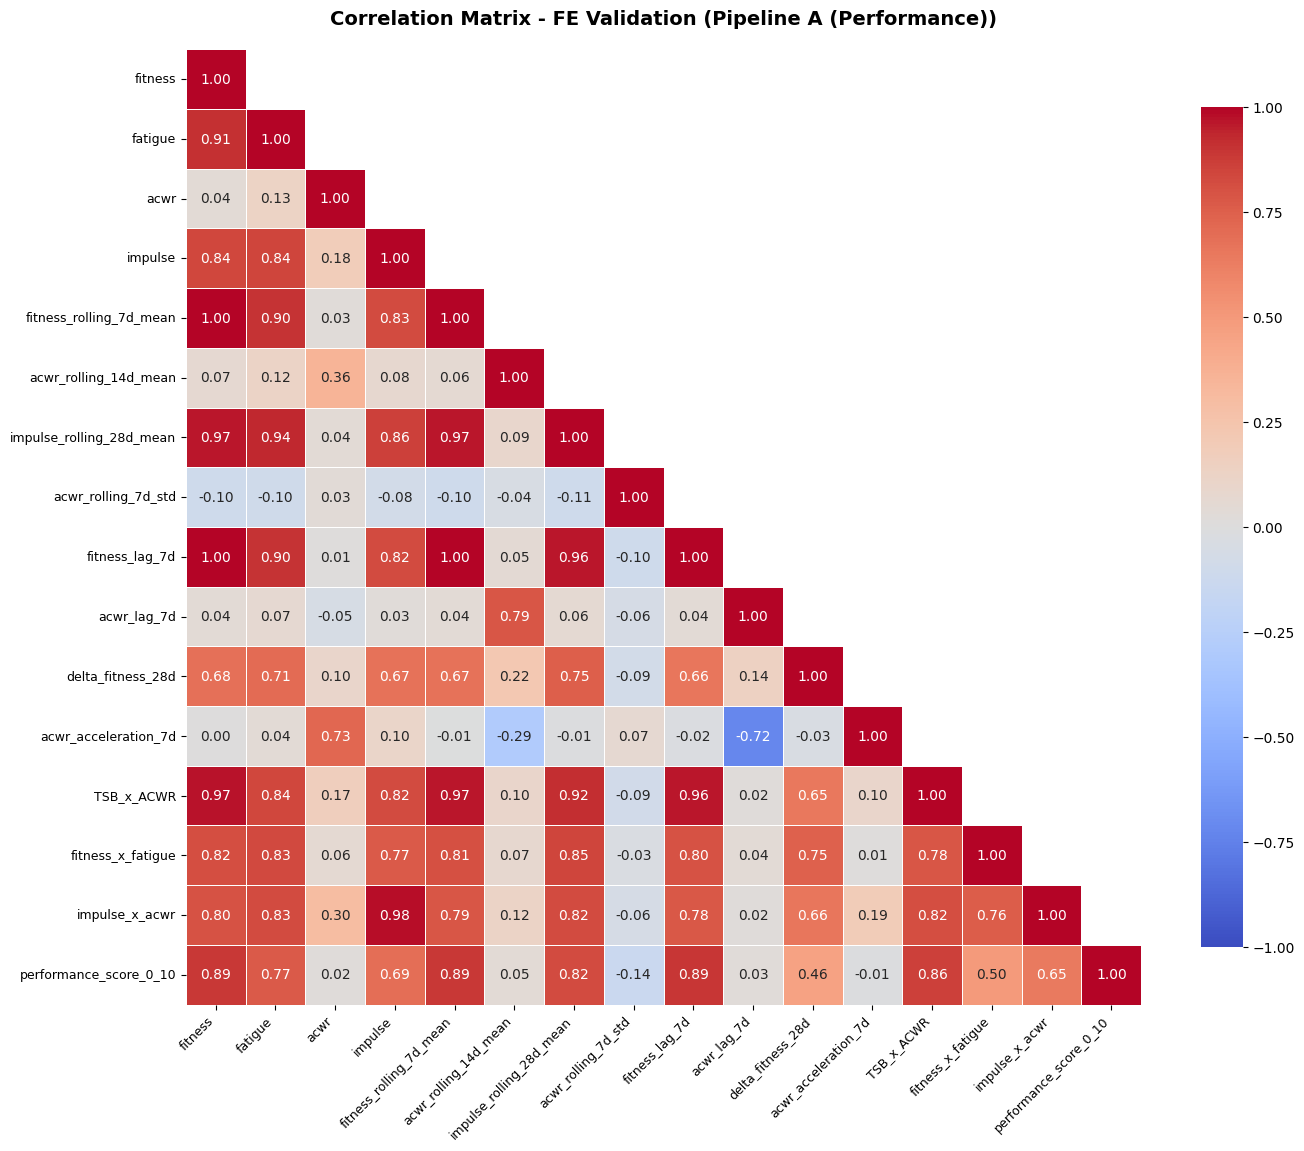


[OK] Heatmap salvata: visualizations/IMPETUS_FE_Correlation_Heatmap_A.png

--------------------------------------------------------------------------------
[Pipeline B (Injury Risk)] TOP CORRELATIONS vs injury_risk_score
--------------------------------------------------------------------------------
 1. acwr                               : +0.933
 2. acwr_acceleration_7d               : +0.682
 3. acwr_rolling_14d_mean              : +0.328
 4. impulse_x_acwr                     : +0.281
 5. acwr_rolling_7d_std                : +0.163
 6. impulse                            : +0.158
 7. TSB_x_ACWR                         : +0.147
 8. fatigue                            : +0.106
 9. delta_fitness_28d                  : +0.079
10. fitness_x_fatigue                  : +0.060
11. acwr_lag_7d                        : -0.055
12. fitness                            : +0.030
13. impulse_rolling_28d_mean           : +0.026
14. fitness_rolling_7d_mean            : +0.016
15. fitness_lag_7d       

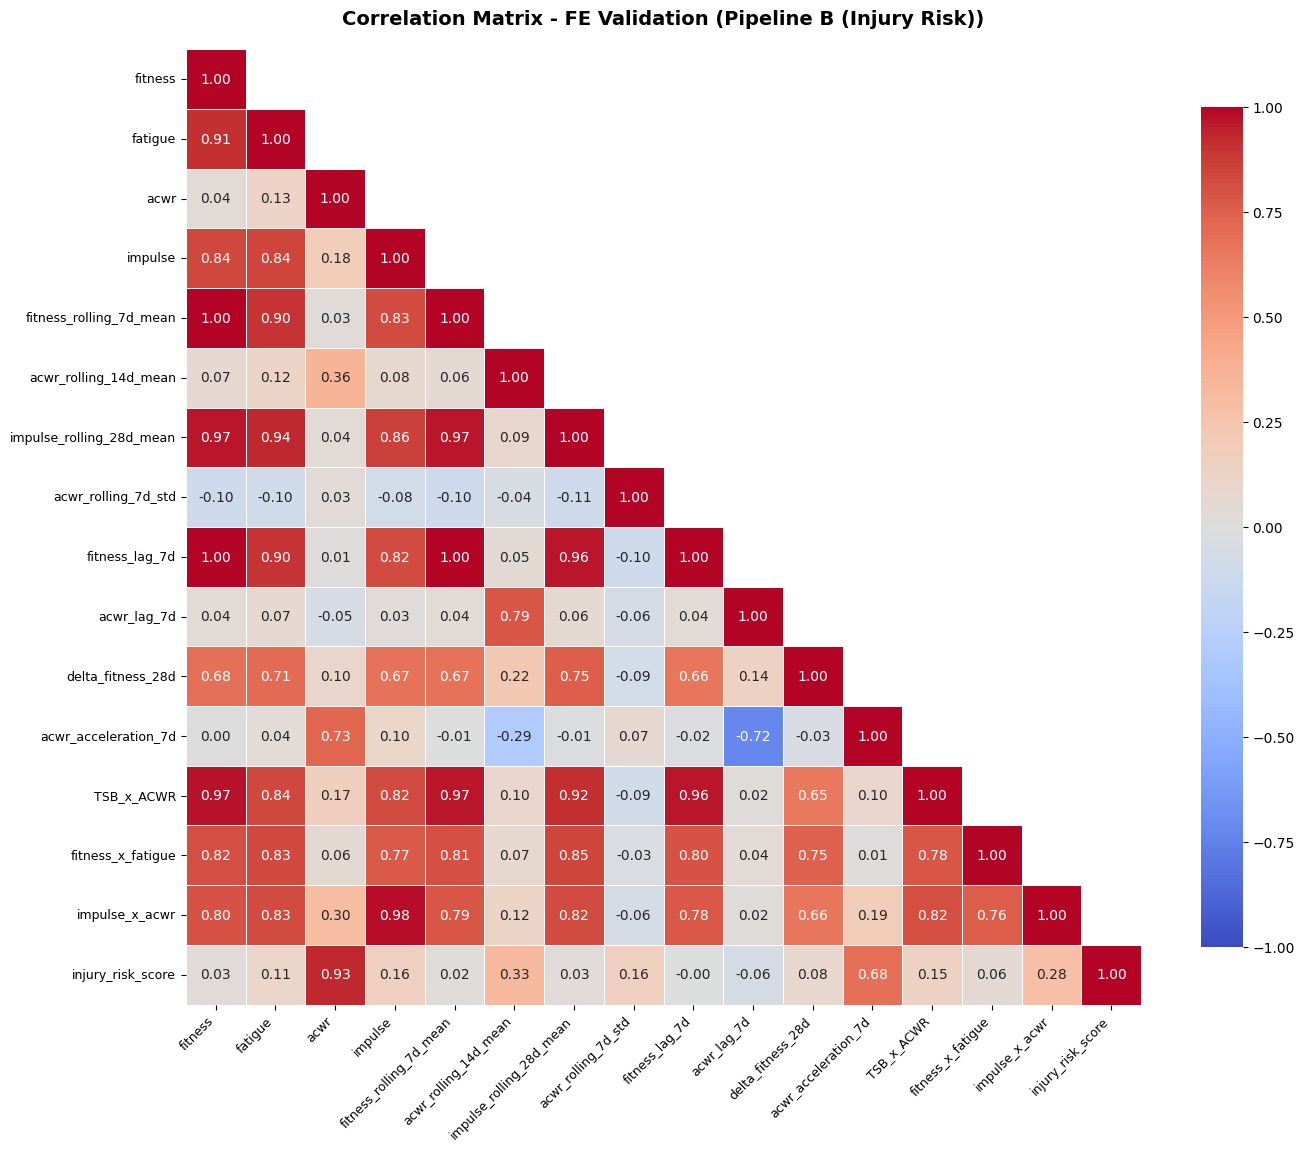


[OK] Heatmap salvata: visualizations/IMPETUS_FE_Correlation_Heatmap_B.png


In [25]:
# ============================================================================
# CELL 11: Correlation Heatmap - FE Validation (A e B)
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "=" * 80)
print("SEZIONE 10: CORRELATION HEATMAP - FE VALIDATION (A/B)")
print("=" * 80)

def corr_validation_block(df_in, feature_cols_in, target_col, title_suffix, out_name):
    # Seleziona subset per heatmap (filtra colonne esistenti)
    features_for_heatmap = [
        'fitness', 'fatigue', 'acwr', 'impulse',
        'fitness_rolling_7d_mean', 'acwr_rolling_14d_mean',
        'impulse_rolling_28d_mean', 'acwr_rolling_7d_std',
        'fitness_lag_7d', 'acwr_lag_7d',
        'delta_fitness_28d', 'acwr_acceleration_7d',
        'TSB_x_ACWR', 'fitness_x_fatigue', 'impulse_x_acwr',
        target_col
    ]
    features_for_heatmap = [c for c in features_for_heatmap if c in df_in.columns]

    df_corr = df_in[features_for_heatmap].copy()
    corr_matrix = df_corr.corr()

    # ---- Correlazioni feature -> target (ranking)
    corr_target = corr_matrix[target_col].drop(target_col).sort_values(key=np.abs, ascending=False)

    print("\n" + "-"*80)
    print(f"[{title_suffix}] TOP CORRELATIONS vs {target_col}")
    print("-"*80)
    for i, (feat, val) in enumerate(corr_target.head(15).items(), 1):
        print(f"{i:2d}. {feat:35s}: {val:+.3f}")

    # ---- Multicollinearity check (solo feature-feature, escludi target)
    feat_only = [c for c in features_for_heatmap if c != target_col]
    high_corr_pairs = []
    moderate_corr_pairs = []

    for i in range(len(feat_only)):
        for j in range(i+1, len(feat_only)):
            f1, f2 = feat_only[i], feat_only[j]
            v = abs(corr_matrix.loc[f1, f2])
            if v > 0.90:
                high_corr_pairs.append((f1, f2, v))
            elif v > 0.75:
                moderate_corr_pairs.append((f1, f2, v))

    print("\nMULTICOLLINEARITY CHECK (feature-feature):")
    print(f"  Critical pairs (|corr|>0.90): {len(high_corr_pairs)}")
    print(f"  Moderate pairs (0.75-0.90): {len(moderate_corr_pairs)}")

    if high_corr_pairs:
        print("\nCRITICAL (|corr| > 0.90) - expected with rolling/lag; monitor:")
        for f1, f2, v in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)[:15]:
            print(f"  {f1:30s} <-> {f2:30s}: {v:.3f}")

    # ---- Heatmap plot
    fig, ax = plt.subplots(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    sns.heatmap(
        corr_matrix, mask=mask,
        annot=True, fmt=".2f",
        cmap="coolwarm", center=0,
        square=True, linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        vmin=-1, vmax=1, ax=ax
    )

    ax.set_title(f"Correlation Matrix - FE Validation ({title_suffix})", fontweight="bold", fontsize=14, pad=18)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=9)
    plt.tight_layout()

    viz_dir = Path("visualizations")
    viz_dir.mkdir(exist_ok=True)
    out_path = viz_dir / out_name
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"\n[OK] Heatmap salvata: {out_path}")
    return corr_matrix, corr_target, high_corr_pairs, moderate_corr_pairs

# --- A
corr_matrix_A, corrA, highA, modA = corr_validation_block(
    df_in=train_final_A,
    feature_cols_in=feature_cols_A,
    target_col="performance_score_0_10",
    title_suffix="Pipeline A (Performance)",
    out_name="IMPETUS_FE_Correlation_Heatmap_A.png"
)

# --- B
corr_matrix_B, corrB, highB, modB = corr_validation_block(
    df_in=train_final_B,
    feature_cols_in=feature_cols_B,
    target_col="injury_risk_score",
    title_suffix="Pipeline B (Injury Risk)",
    out_name="IMPETUS_FE_Correlation_Heatmap_B.png"
)
